# $\textbf{Data Loading}$



In [1]:
from google.colab import drive
from shutil import copyfile
import pandas as pd
import re
from matplotlib import pyplot as plt
import numpy as np
import zipfile
import random as python_random
import os
import zipfile
from scipy.signal import spectrogram
from scipy.io import loadmat
from scipy.signal import resample, tukey
from sklearn.preprocessing import LabelEncoder
import io
import csv
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam

In [2]:
drive.mount('/content/gdrive')
copyfile('gdrive/My Drive/DataLoading_DL/XTrain-set.npy', 'XTrain-set.npy')
copyfile('gdrive/My Drive/DataLoading_DL/XTest-set.npy', 'XTest-set.npy')
copyfile('gdrive/My Drive/DataLoading_DL/XVal-set.npy', 'XVal-set.npy');

copyfile('gdrive/My Drive/DataLoading_DL/YTrain-set.npy', 'YTrain-set.npy')
copyfile('gdrive/My Drive/DataLoading_DL/YTest-set.npy', 'YTest-set.npy')
copyfile('gdrive/My Drive/DataLoading_DL/YVal-set.npy', 'YVal-set.npy');

Mounted at /content/gdrive


In [3]:
# Load only Train dataset:

x_train = np.load('XTrain-set.npy')
y_train = np.load('YTrain-set.npy')

x_test = np.load('XTest-set.npy')
y_test = np.load('YTest-set.npy')

x_val = np.load('XVal-set.npy')
y_val = np.load('YVal-set.npy')

N to A 6.842735042735042
N to O 2.017641129032258
N to ~ 16.748953974895397


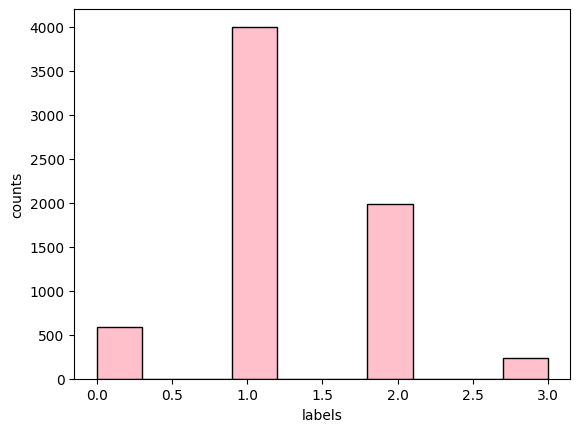

In [4]:
plt.hist(y_train, color='pink', edgecolor='black')
plt.xlabel('labels')
plt.ylabel('counts')


print('N to A', len(np.argwhere(y_train == 1))/len(np.argwhere(y_train == 0)));
print('N to O', len(np.argwhere(y_train == 1))/len(np.argwhere(y_train == 2)));
print('N to ~', len(np.argwhere(y_train == 1))/len(np.argwhere(y_train == 3)));

# $\textbf{Preprocessing}$

Test 1) Use dropout of bursts;
Test 2) Use data augmentation assuming the rate of heartbeat.

In [5]:
def apply_dropout_bursts(ecg_signal, fs, dropout_duration_ms=50, dropout_rate=0.05):
    """
    Apply dropout bursts to the ECG signal.

    :param ecg_signal: numpy array of the ECG signal
    :param fs: sampling frequency of the ECG signal in Hz
    :param dropout_duration_ms: duration of each dropout burst in milliseconds
    :param dropout_rate: fraction of the signal length where dropouts will occur
    :return: numpy array of the augmented ECG signal
    """
    signal_length = len(ecg_signal)
    dropout_duration_samples = int((dropout_duration_ms / 1000) * fs)
    num_dropouts = int(signal_length * dropout_rate)

    dropout_indices = np.random.randint(0, signal_length - dropout_duration_samples, num_dropouts)

    for idx in dropout_indices:
        ecg_signal[idx:idx + dropout_duration_samples] = 0

    return ecg_signal

def random_resample(ecg_signal, fs, target_heart_rate_range=(60, 120), original_heart_rate=80):
    """
    Randomly resample the ECG signal to simulate different heart rates.

    :param ecg_signal: numpy array of the ECG signal
    :param fs: sampling frequency of the ECG signal in Hz
    :param target_heart_rate_range: tuple specifying the range of heart rates to simulate
    :param original_heart_rate: assumed original heart rate of the signal in bpm
    :return: numpy array of the resampled ECG signal
    """
    target_heart_rate = np.random.uniform(target_heart_rate_range[0], target_heart_rate_range[1])
    resampling_factor = target_heart_rate / original_heart_rate
    new_length = int(len(ecg_signal) * resampling_factor)

    resampled_signal = resample(ecg_signal, new_length)

    return resampled_signal

In [6]:
fs = 300 # Hz
delta_t = 1/fs

print('Sampling frequency: ', fs, ' Hz')
print('Delta t: ', delta_t, ' s')

Sampling frequency:  300  Hz
Delta t:  0.0033333333333333335  s


### $\textbf{Test usage on single signal}$

In [7]:
# Test usage

# Apply dropout bursts
augmented_signal_dropout = apply_dropout_bursts(x_train[0].copy(), fs)

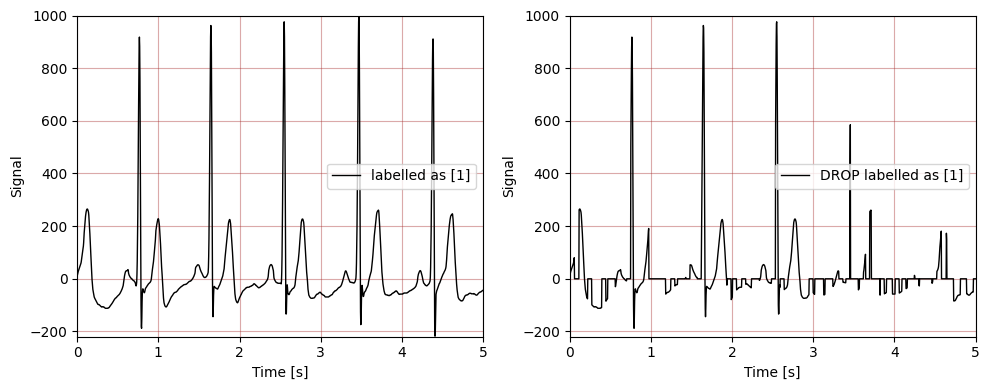

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].plot(delta_t * np.arange(len(x_train[0])), x_train[0], label=f'labelled as {y_train[0]}',
          linewidth=1, c='black')
ax[0].legend()
ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel('Signal')
ax[0].grid(True, c='brown', alpha=0.4)
ax[0].set_xlim(0, 5)
ax[0].set_ylim(-220, 1000)

ax[1].plot(delta_t * np.arange(len(augmented_signal_dropout)), augmented_signal_dropout, label=f'DROP labelled as {y_train[0]}',
          linewidth=1, c='black')
ax[1].legend()
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('Signal')
ax[1].grid(True, c='brown', alpha=0.4)
ax[1].set_xlim(0, 5)
ax[1].set_ylim(-220, 1000)

plt.tight_layout()

## $\textbf{Dropout}$

In [9]:
# Find A, O, and ~ signals and augment data

a_signals = x_train[np.argwhere(y_train == 0)[:, 0]]
a_labels = y_train[np.argwhere(y_train == 0)[:, 0]]

n_signals = x_train[np.argwhere(y_train == 1)[:, 1]]
n_labels = y_train[np.argwhere(y_train == 1)[:, 0]]

print('A Data ', a_signals.shape)
print('A Label ', a_labels.shape)

print('N Data ', n_signals.shape)
print('N Label ', n_labels.shape)

A Data  (585, 9000)
A Label  (585, 1)
N Data  (4003, 9000)
N Label  (4003, 1)


In [10]:
# Apply dropout bursts
a_signals_dropout = apply_dropout_bursts(a_signals.copy(), fs)
a_signals_resample = random_resample(a_signals.copy(), fs)

In [11]:
# Set new y_train for resample

a_labels_resample = np.repeat([[0]], len(a_signals_resample), axis=0)

In [12]:
# Add new signals to train data

new_x_train = np.concatenate((x_train, a_signals, a_signals_resample), axis=0)
new_y_train = np.concatenate((y_train, a_labels, a_labels_resample), axis=0)

print('old shape Xtrain ', x_train.shape)
print('old shape Ytrain ', y_train.shape)
print('')
print('new shape Xtrain ', new_x_train.shape)
print('new shape Ytrain ', new_y_train.shape)

old shape Xtrain  (6811, 9000)
old shape Ytrain  (6811, 1)

new shape Xtrain  (8175, 9000)
new shape Ytrain  (8175, 1)


We now produce spectrograms of the time data. The spectrogram is computed using a Tukey window of length 64 (corresponding to 213ms at the 300Hz sampling rate of the challenge data and resulting in 33 effective frequency bins) with shape parameter 0.25 and 50% overlap.

In [13]:
def compute_log_spectrogram(ecg_signal, fs, window_length, shape_param, overlap_fraction):
    """
    Compute the one-sided spectrogram of the ECG signal and apply a logarithmic transform. Default window is Tukey.

    :param ecg_signal: numpy array of the ECG signal
    :param fs: sampling frequency of the ECG signal in Hz
    :param nperseg: length of each segment for the spectrogram
    :param noverlap: number of points to overlap between segments
    :return: frequencies, times, and the logarithmically transformed spectrogram
    """

    # Create the Tukey window
    window = tukey(window_length, alpha=shape_param)

    # Number of points to overlap

    noverlap = int(window_length * overlap_fraction)

    # Compute the spectrogram
    f, t, Sxx = spectrogram(ecg_signal, fs, window=window, nperseg=window_length, noverlap=noverlap)

    # Apply the logarithmic transform
    Sxx_log = np.log1p(Sxx)  # Use log1p to avoid log(0)

    return f, t, Sxx_log

In [14]:
window_length = 64  # Tukey window length in samples
shape_param = 0.25  # shape parameter of the Tukey window
overlap_fraction = 0.5  # 50% overlap

frequencies, times, log_spectrogram_train = compute_log_spectrogram(new_x_train, fs, window_length, shape_param, overlap_fraction)

<ipython-input-13-6040e04a6ee8>:13: DeprecationWarning: Importing tukey from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.tukey' or the convenience function 'scipy.signal.get_window' instead.
  window = tukey(window_length, alpha=shape_param)


In [15]:
# See resulting array shape
log_spectrogram_train.shape

(8175, 33, 280)

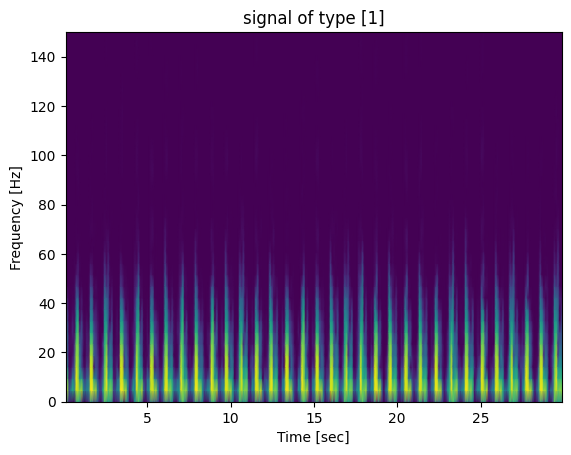

In [16]:
# Spectrogram of first signal

plt.pcolormesh(times, frequencies, log_spectrogram_train[0], shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title(f'signal of type {y_train[0]}')
plt.show()

In [17]:
# Create spectrogram also of Val and Test set as they are

frequencies_t, times_t, log_spectrogram_test = compute_log_spectrogram(x_test, fs, window_length, shape_param, overlap_fraction)
frequencies_v, times_v, log_spectrogram_val = compute_log_spectrogram(x_val, fs, window_length, shape_param, overlap_fraction)

<ipython-input-13-6040e04a6ee8>:13: DeprecationWarning: Importing tukey from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.tukey' or the convenience function 'scipy.signal.get_window' instead.
  window = tukey(window_length, alpha=shape_param)


In [18]:
# Rescale the data using MinMax scaling

def MinMaxScaler(array, lower_limit, upper_limit):
    return (array-lower_limit)/(upper_limit-lower_limit)

x_max = np.max(log_spectrogram_train)
x_min = np.min(log_spectrogram_train)

X_train_scaled = MinMaxScaler(log_spectrogram_train, x_min, x_max)
X_val_scaled   = MinMaxScaler(log_spectrogram_val, x_min, x_max)

# $\textbf{Neural Network}$

In [19]:
input_shape = (33, 280, 1)  # Adjusted input shape for the log spectrogram (heigth, width, scale)
num_blocks = 3  # Number of blocks
num_filters = 32  # Number of filters in each convolutional layer

In [20]:
def conv_block(input_tensor, num_layers, initial_channels, block_name):
    x = input_tensor
    channels = initial_channels
    for i in range(num_layers):
        x = layers.Conv2D(channels, (5, 5), padding='same', name=f'{block_name}_conv_{i+1}')(x)
        x = layers.BatchNormalization(name=f'{block_name}_bn_{i+1}')(x)
        x = layers.ReLU(name=f'{block_name}_relu_{i+1}')(x)
        if i == num_layers - 1:  # Apply max-pooling only in the last layer
            x = layers.MaxPooling2D((2, 2), name=f'{block_name}_pool')(x)
            channels += 32
    return x, channels

def ConvBlock4(input_tensor, initial_channels, block_name):
    return conv_block(input_tensor, 4, initial_channels, block_name)

In [21]:
def create_cnn(input_shape):
    inputs = layers.Input(shape=input_shape)
    x, channels = ConvBlock4(inputs, initial_channels=64, block_name='ConvBlock4_1')
    x, channels = ConvBlock4(x, initial_channels=channels, block_name='ConvBlock4_2')
    x, channels = ConvBlock4(x, initial_channels=channels, block_name='ConvBlock4_3')

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(4, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

input_shape = (33, 280, 1)
cnn_model = create_cnn(input_shape)
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 33, 280, 1)]      0         
                                                                 
 ConvBlock4_1_conv_1 (Conv2  (None, 33, 280, 64)       1664      
 D)                                                              
                                                                 
 ConvBlock4_1_bn_1 (BatchNo  (None, 33, 280, 64)       256       
 rmalization)                                                    
                                                                 
 ConvBlock4_1_relu_1 (ReLU)  (None, 33, 280, 64)       0         
                                                                 
 ConvBlock4_1_conv_2 (Conv2  (None, 33, 280, 64)       102464    
 D)                                                              
                                                             

In [22]:
batch_size = 20
epochs = 100

from keras.callbacks import EarlyStopping
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [23]:
from keras.utils import to_categorical

# Assuming y_train and y_val are your target labels
num_classes = 4  # Replace with the number of classes in your dataset
y_train_encoded = to_categorical(new_y_train, num_classes)
y_val_encoded = to_categorical(y_val, num_classes)

In [24]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(new_y_train),
    y=new_y_train.flatten()
)
class_weights_dict = dict(enumerate(class_weights))

In [25]:
# Fit the model
history = cnn_model.fit(
    x=X_train_scaled,
    y=y_train_encoded,
    epochs=epochs,
    validation_data=(X_val_scaled, y_val_encoded),
    callbacks=[early_stopping],
    batch_size=batch_size,
    class_weight=class_weights_dict
)

Epoch 1/100
409/409 [==============================] - 83s 162ms/step - loss: 2.2796 - accuracy: 0.2533 - val_loss: 1.5409 - val_accuracy: 0.0766
Epoch 2/100
409/409 [==============================] - 60s 147ms/step - loss: 1.4025 - accuracy: 0.2741 - val_loss: 1.3388 - val_accuracy: 0.2655
Epoch 3/100
409/409 [==============================] - 61s 150ms/step - loss: 1.3848 - accuracy: 0.2674 - val_loss: 1.4161 - val_accuracy: 0.4108
Epoch 4/100
409/409 [==============================] - 60s 147ms/step - loss: 1.4003 - accuracy: 0.2891 - val_loss: 1.3306 - val_accuracy: 0.6129
Epoch 5/100
409/409 [==============================] - 61s 149ms/step - loss: 1.3406 - accuracy: 0.2980 - val_loss: 1.3421 - val_accuracy: 0.2734
Epoch 6/100
409/409 [==============================] - 61s 149ms/step - loss: 1.3367 - accuracy: 0.2927 - val_loss: 3.7437 - val_accuracy: 0.0925
Epoch 7/100
409/409 [==============================] - 60s 146ms/step - loss: 1.3422 - accuracy: 0.2150 - val_loss: 1.3364 -

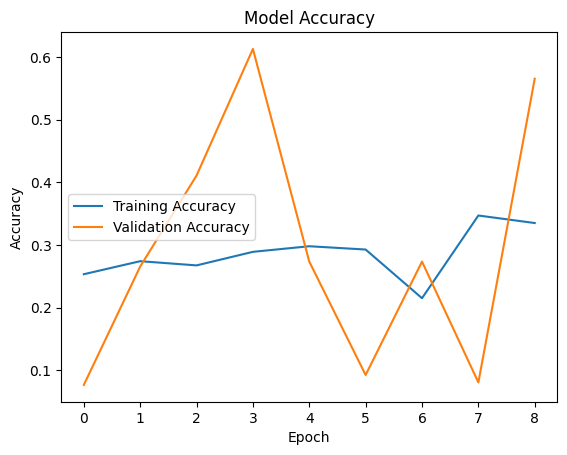

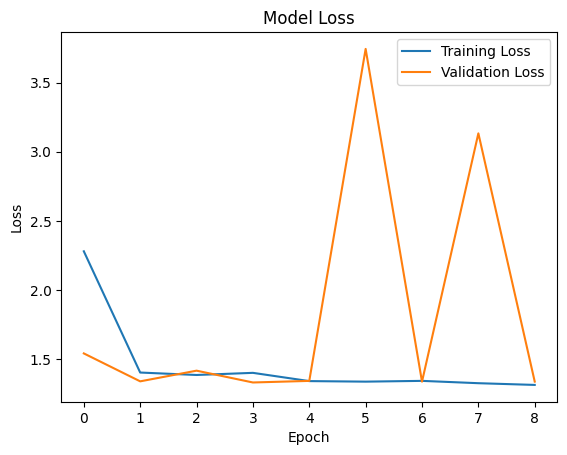

In [26]:
# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

27/27 [==============================] - 6s 116ms/step
Confusion Matrix:
[[ 64   0   0   0]
 [504   0   4   2]
 [246   0   1   0]
 [ 20   0   0   0]]


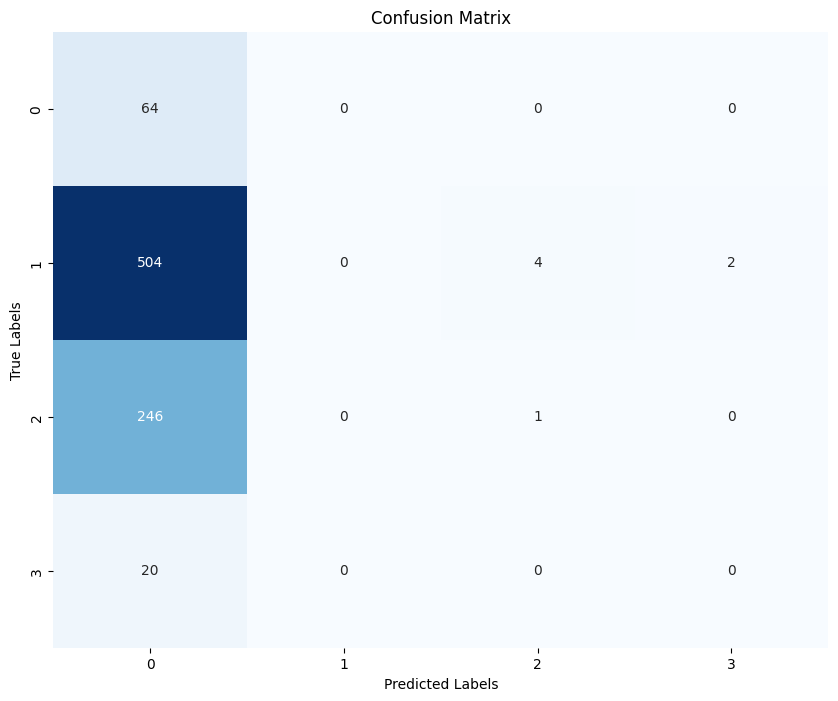

In [27]:
from sklearn.metrics import confusion_matrix

y_pred = cnn_model.predict(log_spectrogram_test)

# Convert probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Now you can compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# If you want to visualize the confusion matrix, you can use libraries like matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()